In [2]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


###The Effect of Noise Correlations in Populations of Diversely Tuned Neurons

Ecker et al. (2011) *Journal of Neuroscience*

Both papers examine the impact of correlated variability on neuronal coding by making use of a metric called Fisher Information. The Fisher Information provides a lower bound on the variance that an unbiased estimator of a signal can achieve, telling us what, theoretically, our best case unbiased estimate would be. An estimator is *unbiased* in the case that $E[\hat{\theta}] = \theta$, where $\theta$ is the parameter or signal we are trying to estimate. We will soon become even better acquainted with the concept of Fisher Information, but first let's introduce the basic models assumed by both authors to position ourselves to better appreciate the results that follow from the information theoretic analysis.

We have a population of $n$ neurons that respond to a stimulus $\theta \in [0, 2\pi)$. The response of neuron $j$ is 

$$
y_j(\theta) = f_j(\theta) + \eta_j(\theta)
$$

where $f_j(\theta)$ is the tuning curve and $\eta(\theta)$ is the trial-to-trial variability in the response of neuron $j$. As will be familiar by now, we are taking the joint response of the population to follow a multivariate Gaussian distribution with covariance $\mathbf{Q(\theta)}$, giving

$$
P(\mathbf{r}|\theta) = Z^{-1}\exp\left(-\frac{1}{2}{(\mathbf{r} - \mathbf{f(\theta)})\mathbf{Q(\theta)}^{-1}(\mathbf{r} - \mathbf{f(\theta)})}\right)
$$

Two points should be made regarding the tuning functions $f_j(\theta)$ and the form of $\mathbf{Q(\theta)}$.

The **tuning curves** are uniformly spaced around the circle so that the preferred orientation or direction of motion, $\phi_j = 2\pi{j}/n$, where $j$ ranges from $0$ to $n-1$ or equivalently from $-n/2$ to $n/2$. In both cases tuning curves take the following form:

$$
f_j(\theta) = \alpha + \beta\exp\left({\gamma[(cos(\theta - \phi_j) - 1]}\right)
$$

The first way in which the two models differ is with respect to the heterogeneity of the tuning curves in the population. 

In the model from Sompolinsky et al. (2001), the tuning curves are homogeneous and vary only in their preferred stimulus value, such that

$$
f_j(\theta) = f(\theta - \phi_j),
$$

whereas in Ecker et al. (2011), in one condition, tuning curve amplitudes were allowed to vary, such that

$$
f_j(\theta) = a_jf(\theta - \phi_j),
$$

and in another condition, $\alpha, \beta$, and $\gamma$ were varied.

Below we define a general function for producing tuning curves according to the above model for $f_j(\theta)$.

In [4]:
def tc(alpha, beta, gamma, theta, phi): # Generate tuning curve examples
    f = alpha + beta*exp(gamma*(cos(theta-phi)-1))
    return f

In the figure below we plot some example *homogeneous* tuning curves of the type used in Sompolinsky et al. (2001), meaning they vary only in their preferred direction, so $a, \alpha, \beta$ and $\gamma$ are all constant.

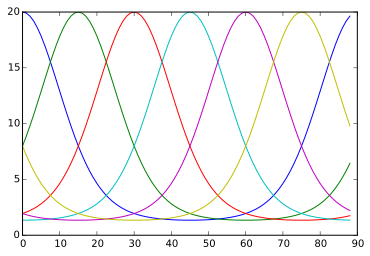

In [3]:
thetas = arange(0,178,2)*2*pi/180
phi = arange(0,180,30)*2*pi/180
for i in phi:
    f = tc(1,19,2, thetas, phi[i])
    plot(f)

Now we generate some example tuning curves with amplitude heterogeneity. In this case we simply multiply the output of our tuning curve function with some scalar.

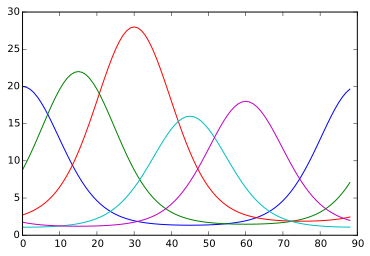

In [4]:
thetas = arange(0,178,2)*2*pi/180
phi = arange(0,180,30)*2*pi/180
amps = [1,1.1,1.4,0.8,0.9,1.3]
idx = arange(0,5,1)
for i in idx:
    f = tc(1,19,2, thetas, phi[i])
    plot(amps[i]*f)

These tuning figures above are analagous to Fig 1E and 1J in Ecker et al. (2011).

Having just dealt with the form of the $\mathbf{f(\theta)}$ in our population model discussed above, let us turn to the **covariance structure** and our $\mathbf{Q(\theta)}$ term from our above model.

We can write $\mathbf{Q(\theta)}$ in the following manner:

$$
\mathbf{Q(\theta)} = \mathbf{S(\theta)RS(\theta)}
$$
or, elementwise as
$$
Q_{jk}(\theta) = \sigma_j(\theta)\sigma_k(\theta)r_{jk}
$$

As mentioned at the end of the last section, the type of correlation structure we will be dealing with now is called a *Limited Range Structure*, and what this means becomes clearer upon closer examination of the correlation matrix $\mathbf{R}$. Limited range correlations, or LRCs, refer to a pattern of correlations where the strength of the correlation coefficient depends on how similar the tuning preferences of the two neurons in the pair are. We can give this idea an explicit form as follows:

$$
r_{jk} = c(|\phi_j \ominus \phi_k|) + \delta(1-c(0))
$$

Here, the $\ominus$ symbol refers to the angular difference between the two stimulus preferences $\phi_j$ and $\phi_k$. In a limited range structure, neurons with more similar tuning preferences are more strongly correlated, so the exact parameterization of our angular difference is as follows:

$$
c(|\phi_j \ominus \phi_k|) = c_0\exp\left(\frac{-|\phi_j \ominus \phi_k|}{L}\right)
$$

Let's take a closer look at the resulting structure.

In [5]:
def lrc(diffs, c_0, L):
    return c_0*exp(-abs(diffs)/L)

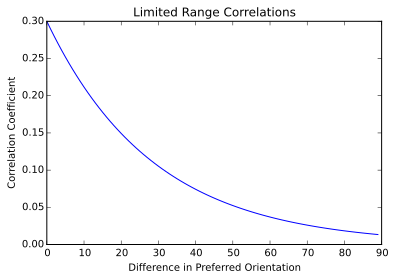

In [6]:
dPhi = arange(0,90,1)*(2*pi/180)
L = 1
c_0 = .3
c = lrc(dPhi, c_0, L)
plot(dPhi*180/(2*pi),c)
xlabel('Difference in Preferred Orientation')
ylabel('Correlation Coefficient')
title('Limited Range Correlations')

From the above we can see that as the difference in preferred orientation of the two neurons in the pair increases, the correlation coefficient decreases.

As we saw above in our definition of $\mathbf{Q(\theta)}$, we made the variance of the neuronal responses, $\sigma_j^2(\theta)$, stimulus dependent, and in Ecker et al. (2011), the noise is *Poisson-like*, such that $\sigma_j^2(\theta) = f_j(\theta)$. This parameterization of the variance is called "proportional noise" (following Wilke and Eurich, 2002), whereas a stimulus independent variance $\sigma_j$ is the "additive noise" case we have already seen, as treated in Sompolinsky et al. 2001. 

Thus, we can already begin to appreciate a number of subtleties regarding these models, and therefore regarding how correlations relate to population coding. In particular, we will see that:

1. The choice of tuning curves being *homogeneous* or *heterogeneous*, and 
2. The choice of noise structure (i.e, additive versus proportional)

can have an important impact on population coding. In order to see this we will use the concept of Fisher Information, which we are now in a position to define more thoroughly and explore in the context of our model elaborated above.

**Fisher Information**

We are interested in how well we can estimate the value of a particular parameter based on neuronal population activity. Remember, ultimately we want to know how different patterns of correlations we see in real data might effect the quality of a population code. We don't know what sort of code neurons use, so we tackle the problem from a theoretical standpoint, and fortunately there is a good deal of work on the problem of parameter estimation. 

Let's take the example of a single neuron to help make this discussion more concrete. Our neuron will prefer orientations of $90^\circ$. We have a model for our neuron's mean firing rates in response to various stimulus orientations, which is the tuning curve shown above. In line with the model we've been working with, we assume that there is some variability around these mean rates, which happens to be Gaussian distributed. Then we can write out neuron's firing rate in the following manner (as we have been doing):

$$ 
r(\theta) = f(\theta) + \eta,
$$

where $\eta \sim \mathcal{N}(0, \sigma^2)$. Now because we have knowledge of the neuron's tuning curve, our task is to estimate the underlying mean rate, which we can then use to determine the orientation that was likely shown (although strictly speaking this is not a great example since, given the symmetry of our neuron's tuning curve, there would be two possible orientations that could elicit a particular mean firing rate, assuming we are not dealing with the peak firing rate. We can pretend that this is not the case).

In order to estimate, we need an estimator (for example, the sample mean of realizations of a random variable). However, as we said before, we are not sure how neurons perform this estimation, so we analyze what, in theory, is the best performance an estimator could achieve under certain circumstances (for example, additive versus proportional noise, or homogeneous versus heterogeneous tuning curves). 

This "best performance" case is called the *Cramer-Rao Lower Bound (CRLB)*, which is the minimum variance of an unbiased estimator of a particular parameter.  Specifically, this variance is bounded in the following manner:

$$
var(\hat{\theta}) \geq \frac{1}{-E\Big[\frac{\partial^2 ln p(x; \theta)}{\partial \theta^2}\Big]} = \frac{1}{I(\theta)}.
$$

In our case we would replace $x$ in $p(x;\theta)$ with $r$. The quantity in the denominator is the Fisher Information, which in the papers we are discussing is referenced by $J$. Thus, the minimum variance an unbiased estimator can achieve is the inverse of the Fisher Information of a random variable, for example $r$, about a parameter $\theta$. To put this another way, if we can calculate the Fisher Information, we know what the best possible scenario is for the performance of an estimator. 

*Fisher Information with Independent Neurons under Additive Gaussian Noise*

To demonstrate this, let's examine the case where all of our neurons are independent. We will otherwise assume the same multivariate Gaussian noise model as above (the difference is that $\mathbf{Q}(\theta)$ is diagonal, and each diagonal element is equal to $\sigma^2$. Our likelihood function then is 

$$
P(\mathbf{r}|\theta) = \frac{1}{(2\pi\sigma^2)^\frac{N}{2}}\exp\left(-\frac{1}{2\sigma^2}\sum_i(r_i - f_i(\theta))^2\right),
$$

and we derive the Fisher Information, which we now call $J$ as follows:

\begin{align}
\frac{\partial ln P}{\partial \theta} &= \frac{1}{\sigma^2}\sum_i(r_i - f_i(\theta))f_i'(\theta) \\
\frac{\partial^2 ln P}{\partial \theta^2} &= \frac{1}{\sigma^2}\sum_i\Big((r_i - f_i(\theta))f_i''(\theta) - \big(f_i'(\theta)\big)^2\Big) \\
E\Big[\frac{\partial^2 ln P}{\partial \theta^2}\Big] &= E\Big[\frac{1}{\sigma^2}\sum_i\Big((r_i - f_i(\theta))f_i''(\theta) - \big(f_i'(\theta)\big)^2\Big)\Big] \\
&= \frac{1}{\sigma^2}\sum_i\Big((E[r_i] - f_i(\theta))f_i''(\theta) - \big(f_i'(\theta)\big)^2\Big) \\
&= -\frac{1}{\sigma^2}\sum_i\big(f_i'(\theta)\big)^2 = -J
\end{align}

so that

$$
var(\hat{\theta}) \geq \frac{\sigma^2}{\sum_i\big(f_i'(\theta)\big)^2} = \frac{\sigma^2}{\mathbf{f'}^T\mathbf{f}}.
$$

Notice from the above expression that, consistent with our previous analyses regarding the SNR, the variance goes to zero in the limit of large N when our population is independent. The above gives us a baseline for comparison of our subsequent results. What we are really interested in here is how correlations between neurons impact coding, and given this we need to derive the Fisher Information for the case in which $\mathbf{Q}(\theta)$ is non-diagonal. Below, we derive the Fisher Information for such a case.

*Fisher Information for General Gaussian with Proportional Noise Case*

One major identity that is required, which we will not prove here, is the following:

$$
\frac{\partial \ln|\mathbf{Q}(\theta)|}{\partial \theta} = tr\big(\mathbf{Q}^{-1}(\theta)\frac{\partial \mathbf{Q}(\theta)}{\partial \theta}\big)
$$

To clean up the notation a bit for the derivation, I will omit the dependence on $\theta$, and we will just have to keep in mind that, until noted at the end of the derivation, $\mathbf{f} = \mathbf{f}(\theta)$ and $\mathbf{Q} = \mathbf{Q}(\theta)$. Also note that $\mathbf{Q'}^{-1}$ is meant to equal $\frac{d\mathbf{Q}^{-1}}{d\theta}$ and $\mathbf{f'} = \frac{d\mathbf{f}}{d\theta}$.

Taking the first derivative of $\ln p(\mathbf{r}|\theta)$, 

$$
\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta} = -\frac{1}{2}\frac{\partial \ln|\mathbf{Q}|}{\partial \theta} - \frac{1}{2}\frac{\partial}{\partial \theta}\big((\mathbf{r}-\mathbf{f})^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f})\big)
$$

Having dealt with the first term in the preceding step, we will focus on the second term.

\begin{align}
 - \frac{1}{2}\frac{\partial}{\partial \theta}\big((\mathbf{r}-\mathbf{f})^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f})\big) &= -\frac{1}{2}\big(-(\mathbf{r}-\mathbf{f})^T\mathbf{Q}^{-1}\mathbf{f'} + (\mathbf{r}-\mathbf{f})^T\mathbf{Q'}^{-1}(\mathbf{r}-\mathbf{f}) - \mathbf{f'}^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f})\big) \\
&= \mathbf{f'}^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f}) - \frac{1}{2}(\mathbf{r}-\mathbf{f})^T\mathbf{Q'}^{-1}(\mathbf{r}-\mathbf{f})
\end{align}

Thus,

$$
\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta} = -\frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) + \mathbf{f'}^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f}) - \frac{1}{2}(\mathbf{r}-\mathbf{f})^T\mathbf{Q'}^{-1}(\mathbf{r}-\mathbf{f})
$$

Recall,

$$
-E\Big[\frac{\partial^2 \ln p(\mathbf{r}|\theta)}{\partial \theta^2}\Big] = E\Big[\big(\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta}\big)^2\Big]
$$

Thus, setting $\mathbf{y} = \mathbf{r} - \mathbf{f}$ and noting that odd order moments, such as $E[\mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{y}] = 0$, we have:

\begin{align}
E\Big[\big(\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta}\big)^2\Big] &= \frac{1}{4}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) + \frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{y}\big] + \mathbf{f'}^T\mathbf{Q}^{-1}E[\mathbf{yy}^T]\mathbf{Q}^{-1}\mathbf{f'} + \frac{1}{4}E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{yy}^T\mathbf{Q'}^{-1}\mathbf{y}\big] \\
&= \frac{1}{4}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) + \frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{y}\big] + \mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{f'} + \frac{1}{4}E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{yy}^T\mathbf{Q'}^{-1}\mathbf{y}\big]
\end{align}

Now, to handle the second term above we need two facts. First, $E[\mathbf{y}^T\mathbf{z}] = tr(E[\mathbf{z}\mathbf{y}^T])$. Second, $\mathbf{Q'}^{-1} = -\mathbf{Q}^{-1}\mathbf{Q'}\mathbf{Q}^{-1}$. Next, we take $\mathbf{Q'}^{-1}\mathbf{y} = \mathbf{z}$, so our expectation becomes 

$$
tr(\mathbf{Q'}^{-1}E[\mathbf{y}\mathbf{y}^T]) = tr(\mathbf{Q'}^{-1}\mathbf{Q}) = -tr(\mathbf{Q}^{-1}\mathbf{Q'}\mathbf{Q}^{-1}\mathbf{Q}) = -tr(\mathbf{Q}^{-1}\mathbf{Q'})
$$

So,
$$
E\Big[\big(\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta}\big)^2\Big] = \frac{1}{4}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) - \frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr(\mathbf{Q}^{-1}\mathbf{Q'}) + \mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{f'} + \frac{1}{4}E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{yy}^T\mathbf{Q'}^{-1}\mathbf{y}\big]
$$

To handle the last term, we need the following fact: $E[\mathbf{y}^T\mathbf{Ay}\mathbf{y}^T\mathbf{By}] = tr(\mathbf{AC})tr(\mathbf{BC}) + 2tr(\mathbf{ACBC})$. Taking $\mathbf{A} = \mathbf{B} = \mathbf{Q'}^{-1}$ and using $E[\mathbf{y}^T\mathbf{z}] = tr(E[\mathbf{z}\mathbf{y}^T])$ and $\mathbf{C} = E[\mathbf{yy}^T]$, we get

$$
E[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{y}\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{y}] = tr(\mathbf{Q'}^{-1}\mathbf{Q})tr(\mathbf{Q'}^{-1}\mathbf{Q}) + 2tr(\mathbf{Q'}^{-1}\mathbf{Q}\mathbf{Q'}^{-1}\mathbf{Q}) = tr(\mathbf{Q}^{-1}\mathbf{Q'})tr(\mathbf{Q}^{-1}\mathbf{Q'}) + 2tr(\mathbf{Q}^{-1}\mathbf{Q'}\mathbf{Q}^{-1}\mathbf{Q'})
$$

Plugging this in, we get our final expression

\begin{align}
E\Big[\big(\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta}\big)^2\Big] &= \frac{1}{4}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) - \frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr(\mathbf{Q}^{-1}\mathbf{Q'}) + \mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{f'} + \frac{1}{4}tr(\mathbf{Q}^{-1}\mathbf{Q'})tr(\mathbf{Q}^{-1}\mathbf{Q'}) + \frac{1}{2}tr(\mathbf{Q}^{-1}\mathbf{Q'}\mathbf{Q}^{-1}\mathbf{Q'}) \\
J &= \mathbf{f'}^T(\theta)\mathbf{Q}^{-1}(\theta)\mathbf{f'}(\theta) + \frac{1}{2}tr(\mathbf{Q}^{-1}(\theta)\mathbf{Q'}(\theta)\mathbf{Q}^{-1}(\theta)\mathbf{Q'}(\theta)) = J_{mean} + J_{cov},
\end{align}

as the two terms are referred to in the text of Ecker et al. (2011).

In the case that $\mathbf{Q}$ does not depend on $\theta$, the second term vanishes leaving,
$$
J_{mean} = \mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{f'}.
$$

In the analysis discussed in this paper, the separate and combined effects of both $J_{mean}$ and $J_{cov}$ will be examined. In order to do so, however, we need to evaluate these two terms, which requires that we invert the covariance matrix $\mathbf{Q}(\theta)$. To do so we will make use of the limited range structure and a property that this imparts to the covariance matrix, making it *circulant*.

**Circulant Matrices**

Circulant matrices are square matrices in which the matrix is specified by a vector $c = (c_0, c_1, ..., c_{n-1})^T$, where each subsequent column is a circular shift of the first with the offset equal to the column index.


\begin{equation}
\begin{bmatrix}
c_0 & c_{(n-1)} & \cdots & c_{1} \\
c_1 & c_0 & & \vdots \\
\vdots & & \ddots & \vdots \\
c_{n-1} & \cdots & \cdots &  c_0
\end{bmatrix}
\end{equation}

We can perform an eigendecomposition of our circulant matrix $\mathbf{R} = \mathbf{U\tilde{R}}\mathbf{U}^*$, where $\mathbf{U}$ is a matrix of eigenvectors and $\mathbf{\tilde{R}}$ is a diagonal matrix of eigenvalues of $\mathbf{Q}$. In the case of circulant matrices, the set of eigenvectors comprise a basis set for the Fourier domain, with an element in $\mathbf{U}$
$$
u_{jk} = \frac{1}{\sqrt{n}}\exp{(-i\omega{jk})}
$$

where $\omega = \frac{2\pi}{n}$. Each element in the diagonal matrix $\mathbf{\tilde{R}}$ can be calculated by taking the Fourier Transform of the first column of $\mathbf{R}, r$:
$$
\tilde{r}_k = \sum_{j=0}^{n-1}r_j\exp{(-i\omega{jk})}
$$

Plugging this into our expression for $\mathbf{Q}$ gives
$$
\mathbf{Q}^{-1}(\theta) = \mathbf{S}^{-1}(\theta)\mathbf{U}\mathbf{\tilde{R}}^{-1}\mathbf{U^\star}\mathbf{S}^{-1}(\theta)
$$

and for the Fisher Information,
\begin{align}
J_{mean} &= \mathbf{f'}^T(\theta)\mathbf{S}^{-1}(\theta)\mathbf{U}\mathbf{\tilde{R}}^{-1}\mathbf{U^\star}\mathbf{S}^{-1}(\theta)\mathbf{f'}(\theta) \\
&= \mathbf{g}^T\mathbf{U}\mathbf{\tilde{R}}^{-1}\mathbf{U^\star}\mathbf{g},
\end{align}

where $g_k = \frac{f'_k}{\sigma_k}$. Next, we note $\mathbf{\tilde{g}} = \sqrt{n}\mathbf{U}^\star\mathbf{g}$ is the discrete Fourier transform of $\mathbf{g}$ (i.e., we project $\mathbf{g}$ onto the Fourier basis). We further evaluate 

\begin{align}
J_{mean} &= \frac{1}{n}\mathbf{\tilde{g}}^\star\mathbf{\tilde{R}}^{-1}\mathbf{\tilde{g}} \\
&= \frac{1}{n}\sum_{k=0}^{n-1}\frac{|\tilde{g_k}|^2}{\tilde{r}}
\end{align}

Information about the stimulus is encoded in changes in firing rates of the neurons in our population. Randomness in these changes and correlations between neurons can cloud our picture of the true underlying changes in rate. From this standpoint we can view the above expression for $J_{mean}$ as a sum of signal to noise ratios for each neuron $k$ in the population, specifically the SNR of the $k$-th Fourier mode of the population. Let's now make this discussion more concrete by evaluating these expressions for a simulated population of neurons. We will need matrices $\mathbf{S}$ and $\mathbf{R}$ to construct $\mathbf{Q}$. We will further need two populations of neurons, one which is homogeneously tuned and another which displays amplitude variability in its tuning.

In [8]:
def angdiff(ang1,ang2):
    return angle(exp(1j*(ang1-ang2)))

Having defined a vector of $n$ preferred orientations and a function for finding the angular difference between two angles, let's first verify that the resulting correlation matrix is indeed circulant. We'll take the angular difference between preferred orientations of the first neuron, compared with all others (called $r1$), and the second neuron, compared with all others (called $r2$), and we will see that the latter vector takes all the same values as the first, but is shifted by one point on the x-axis.

In [9]:
n = 40; # number of neurons
phis = linspace(-pi, pi, n) # set of preferred orientations linearly spaced from -pi to pi

r1 = angdiff(phis[0], phis)
#plot(phis, r1,'.b') #<-- if you would like to plot this uncomment that line
r2 = angdiff(phis[1], phis)
# plot(phis, r2, '.k') #<-- if you would like to plot this uncomment that line
#ylabel('Angular Difference (rads)')
#xlabel('Preferred Orientation (rads)')

We now create the vector $\mathbf{r}$, which is sufficient to define our circulant correlation matrix. Recall, we are working with a limited range correlation structure as defined above. Our definition of $\mathbf{r}$ is therefore,
$$
r_{jk} = c(|\phi_j \ominus \phi_k|) + \delta_{jk}(1-c(0))
$$

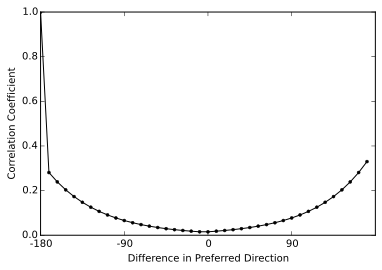

In [10]:
c_0 = .33
L = 1
r = lrc(r1,c_0,L)
r[0] = r[0] + (1-lrc(0,c_0,L))
x = arange(0,40, 1)
plot(x,r,'.-k')
xticks(x[0::10], arange(-180,180,90))
xlabel('Difference in Preferred Direction')
ylabel('Correlation Coefficient')

The above figure is analagous to Fig 1C from Ecker et al. (2011), although circularly shifted, and below we reproduce Fig 1A.

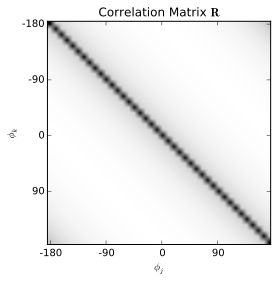

In [11]:
R = zeros([phis.size, phis.size])
c_0 = 0.33
L = 1
for i in arange(phis.size):
    R[i,:] = lrc(angdiff(phis[i],phis), c_0, L)
    R[i,i] = R[i,i] + (1-c_0)
imshow(R)
set_cmap('Greys')
xticks(x[0::10], arange(-180,180,90))
yticks(x[0::10], arange(-180,180,90))
title('Correlation Matrix $\mathbf{R}$')
xlabel('$\phi_j$')
ylabel('$\phi_k$')

Below we construct a set of tuning curves corresponding to the population represented above in the correlation matrix $\mathbf{R}$. To do this, we take our vector of preferred directions, $\mathbf{\phi}$, and pass that as the final argument to the tuning curve function we wrote earlier. We additionally create a vector to use in the construction of $\mathbf{S}$, which we need to compute $\mathbf{Q}$. Recall we are working with two cases, one with proportional noise and one with additive noise, so we will have two such noise vectors. First, we construct our tuning curve populations, one of which is of homogeneous amplitude, the other of which has amplitude variability.

**Homogeneous Population Model**

We start by constructing a set of homogeneous tuning curves for use in subsequent calculations

In [20]:
thetas = linspace(0,2*pi,100)
idx = arange(n)
fh = zeros([idx.size, thetas.size]) # fh for homogeneous populations
for i in idx:
    f = tc(1,19,2, thetas, phis[i])
    fh[i,:] = f

We next construct $\mathbf{Q}$. In the case of additive, isotropic noise, the covariance matrix is simply a scaled version of the correlation matrix. In the case of proportional noise, however, where the variances are equal to the mean firing rate, the covariance matrix is not just a scaled version of the correlation matrix, so we display this case below (analogous to Fig 1B).

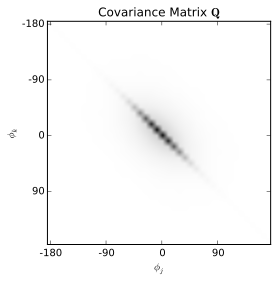

In [13]:
S = diag(ones(idx.size)*10)
Sp = diag(fh[:,0])
Q = dot(dot(S, R), S)
Qp = dot(dot(Sp, R), Sp)
imshow(Qp)
xticks(x[0::10], arange(-180,180,90))
yticks(x[0::10], arange(-180,180,90))
title('Covariance Matrix $\mathbf{Q}$')
xlabel('$\phi_j$')
ylabel('$\phi_k$')

With the homogenous model where the tuning of the population is broad enough relative to the spacing between preferred directions, the population response to a particular stimulus takes the shape of the tuning curve of the neuron with that preferred direction. Below we plot the relationship between $f(\theta)$ and $f'(\theta)$ as we work towards our evaluation of $J_{mean}$. 

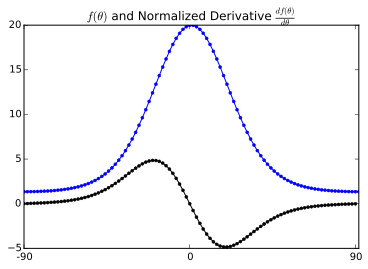

In [14]:
sig = 0.2
f = tc(1,19,2, thetas, pi)
g = diff(f)/sig
plot(thetas,f,'.-b')
plot(thetas[0:-1],g,'.-k')
xticks(thetas[0::49], [-90, 0, 90]) # not actually the precise labels, but approximately rounded
xlim((thetas[0],thetas[-1]))
title('$f(\\theta)$ and Normalized Derivative $\\frac{df(\\theta)}{d\\theta}$')

We now reproduce Fig1 H, D and I, examining the Fourier transforms of $\mathbf{g}$ and of $\mathbf{r}$, which are needed in the evaluation of $J_{mean}$.

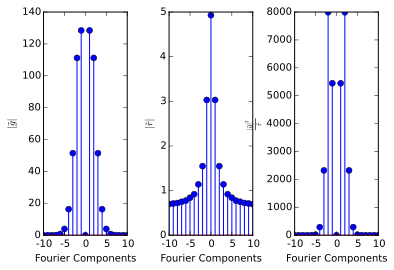

In [15]:
subplot(1,3,1)
gtilde = abs(fft.fft(g))
x = roll(gtilde,10)
gt = x[0:21]
stem(gt)
vals = arange(21)
xticks(vals[0::5], arange(-10,11,5))
xlabel('Fourier Components')
ylabel('$|\\tilde{g}|$')

subplot(1,3,2)
rtilde = abs(fft.fft(r))
x = roll(rtilde,10)
rt = x[0:21]
stem(rt)
xticks(vals[0::5], arange(-10,11,5))
xlabel('Fourier Components')
ylabel('$|\\tilde{r}|$')

subplot(1,3,3)
stem(gt**2/rt)
xticks(vals[0::5], arange(-10,11,5))
xlabel('Fourier Components')
ylabel('$\\frac{|\\tilde{g}|^2}{\\tilde{r}}$')

subplots_adjust(wspace=0.5)

What we see in the above plots is that the tuning curve $f(\theta)$ is smooth, so we expect mostly low frequency components to be non-zero in the Fourier transform of $f(\theta)$. As we can see in the plots of $|\tilde{g}|$ and the normalized plot of $|\tilde{g}|^2$ above, this is indeed the case. The coefficients of the Fourier transform rapidly approach zero. Let's now compare these results to the case of an inhomogeneous population of neurons.

**Random Amplitude Model**

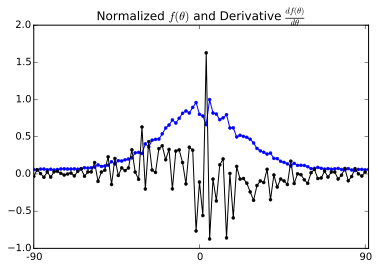

In [21]:
aVar = 0.1
mu = 1
fa = (mu+randn(thetas.size)*aVar)*tc(1,19,2, thetas, pi) # generate population of neurons with variable amplitude curves
ga = diff(fa)/sqrt(max(fa))
plot(thetas,fa/max(fa),'.-b')
plot(thetas[0:-1],ga,'.-k')
xticks(thetas[0::49], [-90,0,90])
xlim((thetas[0],thetas[-1]))
title('Normalized $f(\\theta)$ and Derivative $\\frac{df(\\theta)}{d\\theta}$')

What we can see immediately is that both of these curves are much less smooth than in the case of homogeneous populations. As a result, we expect to see non-zero valued higher frequency components in the Fourier transform of $f'(\theta)$.

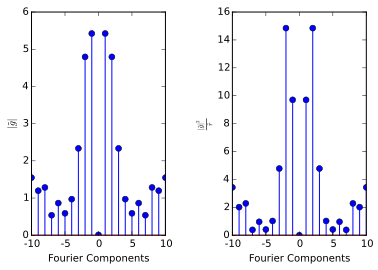

In [17]:
subplot(1,2,1)
gtilde = abs(fft.fft(ga))
xa = roll(gtilde,10)
gat = xa[0:21]
stem(gat)
xticks(vals[0::5], arange(-10,11,5))
xlabel('Fourier Components')
ylabel('$|\\tilde{g}|$')

subplot(1,2,2)
stem(gat**2/rt)
xticks(vals[0::5], arange(-10,11,5))
ylabel('$\\frac{|\\tilde{g}|^2}{\\tilde{r}}$')
xlabel('Fourier Components')

subplots_adjust(wspace=0.5)

In the above, we calculated the components we needed for an evaluation of $J_{mean}$ under two different scenarios, one where the population of neurons had homogeneous tuning curves, and one where the population exhibited amplitude heterogeneity. Although we have not calculated $J_{mean}$ explicitly yet, we can see that if we are summing over $n$ modes of the population, the sum will saturate in the case of the homogeneous population, whereas this does not occur in the heterogeneous case. As can be ascertained by creating another instance of the random amplitude tuning curve vector, the exact values of $|\tilde{g}|$ will depend on the set of amplitudes. Therefore, we need to derive an analytic expression we can use to evaluate $J_{mean}$ separate from the case for homogeneous populations.

We previously took the vector $g_k = \frac{f_k'(\theta)}{\sigma_k} = \frac{f_k'(\theta)}{\sqrt{f_k(\theta)}}$.

We now take $g_k = \sqrt{a_k}\frac{f_k'(\theta)}{\sqrt{f_k(\theta)}} = \sqrt(a_k)q_k$.

We further split $\sqrt{a_k} = \mu + b_k$, where $b_k$ has mean zero and variance equal to $\kappa = Var(\sqrt{a_k})$.

We now evaluate $J_{mean}$:

\begin{align}
\langle J_{mean} \rangle &= \langle[(\mu + \mathbf{b})^T\mathbf{q}]^T\mathbf{R}^{-1}[(\mu + \mathbf{b})^T\mathbf{q}]\rangle \\
&= \mu^2\mathbf{q}^T\mathbf{R}^{-1}\mathbf{q} + 2\mu\mathbf{q}\mathbf{R}^{-1}\langle\mathbf{b}^T\mathbf{q}\rangle + \langle(\mathbf{b}^T\mathbf{q})^T\mathbf{U}\mathbf{\tilde{R}}^{-1}\mathbf{U}^{\star}(\mathbf{b}^T\mathbf{q})\rangle
\end{align}

We are here taking the expected value of the Fisher Information with respect to different instantiations of the heterogeneity, manifested in the form of variable amplitudes. Because the expected value of $\mathbf{b} = \mathbf{0}$, we arrive at the following:

$$
J_{mean} = \mu^2J_{mean}^{hom} + n\kappa d, 
$$

where
$$ 
d = \frac{1}{n^2}\sum_jq_j^2\sum_k\frac{1}{\tilde{r_k}},
$$

since
$$
\langle|[\mathbf{b}^T\mathbf{q}]\mathbf{u}_k|^2\rangle = \sum_i\sum_j\langle b_ib_j \rangle q_iq_j u_{ik}u_{jk}^{\star} = \frac{\kappa}{n}\sum_j q_j^2,
$$

with $u_{ik}u_{jk}^{\star} = \frac{1}{n}$ and $\langle b_ib_j \rangle = \delta_{ij}\kappa$

We can see, then, that the Fisher Information in the heterogeneous tuning case consists of a multiple of the Fisher Information in the homogeneous case, plus another term whose behavior will determine the asymptotic behavior of $J_{mean}$ for the heterogeneous case.

We are now in position to examine what happens to the information capacity of a homogeneously versus heterogeneously tuned population where the variances are independent of the stimulus (ie, no $J_{cov}$ term). We will first examine the homogeneous case.

**Fisher Information of Homogeneous Population**

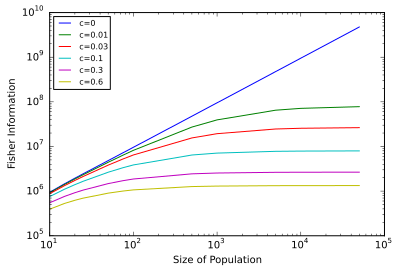

In [20]:
ns = array([10, 15, 20, 25, 50, 75, 100, 500, 1000, 5000, 10000, 50000])
c_0s = [0, .01, .03, .1, .3, .6]
idx = arange(ns.size)
J_hom = zeros(ns.size)
for c in c_0s:
    for i in idx:
        thetas = linspace(0,180,ns[i])*2*pi/180
        f = tc(1,19,2, thetas, 0)
        df = diff(f)/sig
        g = concatenate([df, zeros(1)], axis=0)
        r = lrc(angdiff(thetas,0), c, L)
        r[0] = r[0] + (1-lrc(0,c_0,L))
        gtilde = abs(fft.fft(g))
        rtilde = abs(fft.fft(r))/ns[i]
        J_hom[i] = sum(gtilde**2/rtilde)
    labStr = "c={0}".format(c)
    plot(ns, J_hom, label=labStr)
legend(prop={'size':8}, loc='upper left')
xscale('log')
yscale('log')
xlabel('Size of Population')
ylabel('Fisher Information')

We see in the above plot a familiar story. In the previous two papers we have studied so far, from the standpoint of SNR or Fisher Information, correlations lead to a saturation in the SNR or Fisher Information. What we see next, however, is that this saturation is due to some very specific assumptions in these models. The first of which is that our population is homogeneous. In reality, in the brain, neurons have a wide variety of tuning curve shapes and amplitudes, unlike in our models from the previous papers. The heterogeneity we introduce here is not complete (we are only introducing amplitude heterogeneity), but it is instructive and the full heterogeneous case follows the same pattern, so we will not cover it here.

**Fisher Information of a Heterogeneous Population**

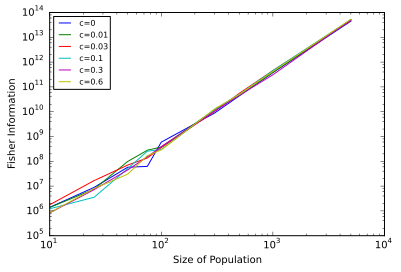

In [18]:
ns = array([10, 25, 50, 75, 100, 300, 500, 1000, 5000])
c_0s = [0, .01, .03, .1, .3, .6]
idx = arange(ns.size)
J_hom = zeros(ns.size)
mu=1
aVar = .25
for c in c_0s:
    for i in idx:
        thetas = linspace(0,180,ns[i])*2*pi/180
        f = (mu+randn(thetas.size)*aVar)*tc(1,19,2, thetas, 0)
        df = diff(f)/sig
        g = concatenate([df, zeros(1)], axis=0)
        r = lrc(angdiff(thetas,0), c, L)
        r[0] = r[0] + (1-lrc(0,c_0,L))
        gtilde = abs(fft.fft(g))
        rtilde = abs(fft.fft(r))/ns[i]
        d = dot(ga,ga)/sum(rtilde)
        J_hom[i] = sum(gtilde**2/rtilde) + aVar*d
    labStr = "c={0}".format(c)
    plot(ns, J_hom, label=labStr)
legend(prop={'size':8}, loc='upper left')
xscale('log')
yscale('log')
xlabel('Size of Population')
ylabel('Fisher Information')

In contrast to the homogeneous case, with heterogeneous tuning curves, we see that regardless of the value of the correlations, as the size of the population increases, the Fisher Information continues to grow.

*Thus, the first major result from this paper is that with heterogeneous populations, the Fisher Information of such a population grows in proportion with the size of the population, $n$, regardless of the degree to which the neurons are pairwise correlated*.

**Fisher Information for Stimulus Independent v Dependent Correlations**

There is one other major condition that affects the saturation of the Fisher Information: whether or not the correlations are stimulus-dependent. If covariances are independent of the stimulus, the $J_{cov}$ term is $0$, since $\frac{d\mathbf{Q}(\theta)}{d\theta} = 0$, when $\mathbf{Q}$ is independent of $\theta$.

Recall,
$$
J_{cov} = \frac{1}{2}Tr[(\mathbf{Q}'(\theta)\mathbf{Q}^{-1}(\theta))^2],
$$

the evaluation of which, as we have seen, is quite simple when $\mathbf{Q}$ is not a function of $\theta$. Therefore, we focus on the only case of relevance, when it is a function of $\theta$, and for notational clarity, we will omit the explicit dependence on $\theta$.

Then, since $\mathbf{Q}' = \mathbf{S'RS} + \mathbf{SRS'}$, we have

\begin{align}
J_{cov} &= \frac{1}{2}Tr[((\mathbf{S'RS} + \mathbf{SRS'})\mathbf{Q}^{-1})^2] \\
&= \frac{1}{2}Tr[((\mathbf{S'RS} + \mathbf{SRS'})\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1})^2] \\
&= \frac{1}{2}Tr[\mathbf{S}'\mathbf{S}^{-1}\mathbf{S}'\mathbf{S}^{-1} + \mathbf{S}'\mathbf{S}^{-1}\mathbf{S}\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1} + \mathbf{S}\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}\mathbf{S}'\mathbf{S}^{-1} + \mathbf{S}\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}\mathbf{S}\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}] \\
&= \frac{1}{2}Tr[\mathbf{S}'\mathbf{S}^{-1}\mathbf{S}'\mathbf{S}^{-1} + \mathbf{S}'\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1} + \mathbf{S}\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}\mathbf{S}'\mathbf{S}^{-1} + \mathbf{S}\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}] \\
\end{align}

Using the fact that $Tr[\mathbf{AB}] = Tr[\mathbf{BA}]$, and substituting $\mathbf{A} = \mathbf{S}\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}$, $\mathbf{B} = \mathbf{S}'\mathbf{S}^{-1}$ in the third term, and $\mathbf{C} = \mathbf{S}\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}$, $\mathbf{D} = \mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}$ in the fourth term, we get after cancellation from inverses aligning,

$$
J_{cov} = Tr[\mathbf{S}'\mathbf{S}^{-1}\mathbf{S}'\mathbf{S}^{-1}] + Tr[\mathbf{S}'\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}]
$$

The first term is easily evaluated as $\mathbf{S}$ is diagonal with entries $S_{kk} = \sigma_k$, so we get

$$
Tr[\mathbf{S}'\mathbf{S}^{-1}\mathbf{S}'\mathbf{S}^{-1}] = \sum_k\big(\frac{\sigma_k'}{\sigma_k}\big)^2 = \sum_kh_k^2
$$

Now to handle the second term, recall that $\mathbf{R}^{-1} = \mathbf{U\tilde{R}}^{-1}\mathbf{U}^{\star}$. Similarly, we can write that $\mathbf{R} = \mathbf{U\tilde{R}}\mathbf{U}^{\star}$. Our second term then becomes,

$$
Tr[\mathbf{S}'\mathbf{R}\mathbf{S}'\mathbf{S}^{-1}\mathbf{R}^{-1}\mathbf{S}^{-1}] = Tr[\mathbf{S}'\mathbf{U\tilde{R}}\mathbf{U}^{\star}\mathbf{S}'\mathbf{S}^{-1}\mathbf{U\tilde{R}}^{-1}\mathbf{U}^{\star}\mathbf{S}^{-1}]
$$

Using the tracing identity we used above, we can rearrange this second term, bringing the $\mathbf{U}^{\star}\mathbf{S}^{-1}$ matrix to the front, giving

$$
Tr[\mathbf{U}^{\star}\mathbf{S}^{-1}\mathbf{S}'\mathbf{U\tilde{R}}\mathbf{U}^{\star}\mathbf{S}'\mathbf{S}^{-1}\mathbf{U\tilde{R}}^{-1}]
$$

Next, recall that when we inverted the covariance matrix, we took the Fourier transform of $\mathbf{R}$, as we have just done again. This is simply the eigendecomposition of the matrix $\mathbf{R}$, since it is circulant. When one takes the Fourier transform of a circulant matrix, it produces a diagonal matrix, so applying the inverse operation will produce a circulant matrix. Thus, $\mathbf{U}^{\star}\mathbf{S}^{-1}\mathbf{S}'\mathbf{U}$ produces a circulant matrix where the first column is the inverse Fourier transform of the diagonal elements of $\mathbf{S}^{-1}\mathbf{S}'$, which we have referred to above as $h_k$. The result, after multiplying by $\mathbf{\tilde{R}}$, is a new matrix $\mathbf{V}$, where

$$
v_{jk} = \frac{1}{n}\tilde{r}_k\tilde{h}_{k-j}
$$

Therefore, $\mathbf{U}^{\star}\mathbf{S}'\mathbf{S}^{-1}\mathbf{U}\mathbf{\tilde{R}}^{-1}$, produces a new matrix $\mathbf{W}$, where

$$
w_{jk} = \frac{1}{n} \frac{\tilde{h}_{k-j}}{\tilde{r}_k}.
$$

Our second term then becomes $Tr[\mathbf{VW}]$. The first row of $\mathbf{V}$ times the first row of $\mathbf{W}$ gives a sum,

$$
\sum_{k=0}^{n-1} \frac{\tilde{r}_{k+1} \tilde{h}_k \tilde{h}_{-k}}{\tilde{r}_j},
$$

Taking the trace of $\mathbf{VW}$ can now be seen to be a sum over (the diagonal terms which are themselves) sums. Because $\tilde{h}$ is periodic and symmetric about its $0^{th}$ component, we can group the $\tilde{r}$ terms according to which $\tilde{h}_k$ multiplies them, after which one of the sums can be incorporated into a circular convolution of $\tilde{r}$ with its pointwise inverse, leaving:

$$
\frac{1}{n^2}\sum_{l=0}^{n-1} |\tilde{h_l}|^2 \Big[\tilde{r} \ast \frac{1}{\tilde{r}}\Big]_l.
$$

This sum over $l$, is the sum over the diagonal terms in the matrix $\mathbf{VW}$, and the subscript on the convolution refers to the $l^{th}$ component of the convolution.

Thus, our expression for $J_{cov}$ is
$$
J_{cov} = \sum_{l=0}^{n-1} |h_l|^2 + \frac{1}{n^2}\sum_{l=0}^{n-1} |\tilde{h_l}|^2 \cdot \Big[\tilde{r} \ast \frac{1}{\tilde{r}}\Big]_l
$$

Interestingly, upon examination of this term, we can see that there is no dependence of $J_{cov}$ on tuning curve amplitude. That is, this term holds equally for homogeneous versus heterogeneous populations. The only factor that makes a difference, then, is whether the neuronal variances are independent of the stimulus or not. In Sompolinsky et al (2001) variances (and covariances) were assumed to be independent of the stimulus, and as a result the only term that mattered for the Fisher Information was $J_{mean}$, which as we saw above, saturates in the large $n$ limit for homogeneous populations. 

What is the effect of $J_{cov}$ on the Fisher Information and how does it relate to population size? Taking the limit of $n\to\infty$, we see that the second term goes to $0$ and the first term grows with $n$, since it is a sum over $n$ terms which themselves are independent of $n$, so

$$
\lim_{n\to\infty} J_{cov} = O(n) + 0.
$$

Thus, we arrive at the second major result of Ecker et. al. (2011), that *with variances that are stimulus dependent, the Fisher Information again grows in proportion to the population size*.

Below we visualize $\tilde{h}$ and its Fourier transform, relevant to the above discussion.

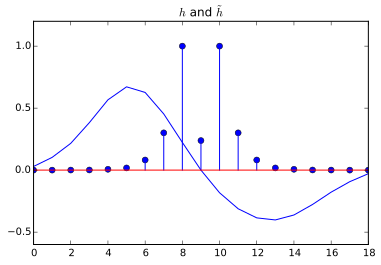

In [21]:
thetas = linspace(0,2*pi,20)
f = tc(1,19,2, thetas, pi)
h = diff(f)/f[0:-1]
plot(h)
ht = abs(fft.fft(h))
stem(roll(ht,9)/max(ht))
title('$h$ and $\\tilde{h}$')

Above, we studied the behavior of a correlated neuronal population in the limit of large population size. We saw that in the case of homogeneous populations with stimulus-independent variance, the Fisher Information saturates in the presence of correlations. However, with heterogeneous populations or stimulus-dependent variance, the Fisher Information grows in proportion to the population size.

We now examine what is the **effect of increasing correlations on the accuracy of the population code**.

We can begin by examining the relationship between a correlated case and an independent case in the limit of large population size, calculating a relative $J_{mean}$ which is the ratio of the two cases.

$$
\lim_{n \to \infty} \frac{\langle J_{mean}|c>0\rangle}{\langle J_{mean}|c=0\rangle} = \lim_{n \to \infty} \frac{\mu^2J_{mean}^{hom} + n\kappa d}{\sum_j q_j^2}.
$$

The denominator comes from the fact that in independent populations $\tilde{r} = 1$, so the second term

$$
n\kappa d = \frac{\kappa}{n}\sum_j q_j^2 \sum_k \frac{1}{\tilde{r_k}} = \kappa\sum_j q_j^2,
$$

and
$$
(\mu^2 + \kappa)\sum_j q_j^2 = \sum_j q_j^2
$$

since $E[b] = 0$ and $\mu^2 + \kappa = E[\sqrt{a}^2] = E[\mu^2] = 1$.

Returning to our ratio, then,
$$
\lim_{n \to \infty} \frac{\mu^2J_{mean}^{hom} + n\kappa d}{\sum_j q_j^2} = \lim_{n \to \infty} \frac{\mu^2J_{mean}^{hom} + \frac{\kappa}{n}\sum_j q_j^2 \sum_k \frac{1}{\tilde{r_k}}}{\sum_j q_j^2}
$$

The denominator increases in proportion to $n$, so the first term goes to $0$, while in the second term becomes $\frac{1}{n}\sum_k \frac{1}{\tilde{r_k}}$ approaches $\frac{1}{1-c_0}$. Thus,

$$
\lim_{n \to \infty} \frac{\mu^2J_{mean}^{hom} + n\kappa d}{\sum_j q_j^2} = \frac{\kappa}{1-c_0}.
$$

Values of this limit less than $1$, of course, mean that the Fisher Information for the independent case is higher than the case with correlations, which would suggest correlations are detrimental (even if they do not cause a saturation on their own). However, from the above expression we can see that there is a point at which the correlated case has a higher Fisher Information, which occurs whenver $\kappa > 1-c_0$. To do this, we actually have to increase correlations, which means that with heterogeneous populations, there is a point at which increasing correlations, increases the Fisher Information relative to the independent case.